In [19]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as T
import librosa
import librosa.display
import IPython.display as ipd
import matplotlib.pyplot as plt
import random

# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


In [20]:
# i = the number in accents range: 1-60
# j = the number pronounced 0-9
# k = variation 0-49
# f'/kaggle/input/audio-mnist/data/0{i}/{j}_0{i}_{k}.wav'
output_dir = '/kaggle/working/'
input_dir = '/kaggle/input/audio-mnist/data/01/'

In [21]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [62]:
BATCH_SIZE = 256
EPOCHS = 5
LR = 1e-3

In [63]:
feature_transform = T.Compose([
    T.ToPILImage(),
    T.Resize((200,200)),
    T.ToTensor()
])

label_transform = T.Compose([
    T.ToTensor()
])

In [64]:
def wav2melSpec(AUDIO_PATH):
    audio, sr = librosa.load(AUDIO_PATH)
    return librosa.feature.melspectrogram(y=audio, sr=sr)

def imgSpec(ms_feature):
    fig, ax = plt.subplots()
    ms_dB = librosa.power_to_db(ms_feature, ref=np.max)
    print(ms_feature.shape)
    img = librosa.display.specshow(ms_dB, x_axis='time', y_axis='mel', ax=ax)
    fig.colorbar(img, ax=ax, format='%+2.0f dB')
    ax.set(title='Mel-frequency spectrogram');
    
def hear_audio(AUDIO_PATH):
    audio, sr = librosa.load(AUDIO_PATH)
    
    print("\t", end="")
    ipd.display(ipd.Audio(data=audio, rate=sr))
    
    
def get_audio_info(path, show_melspec=False, label=None):
    spec = wav2melSpec(path)
    if label is not None:
        print("Label:", label)
    if show_melspec is not False:
        imgSpec(spec)
    hear_audio(path)

(128, 21)
	

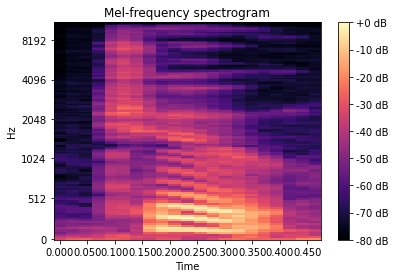

In [65]:
# spec = wav2melSpec('/kaggle/input/audio-mnist/data/01/0_01_0.wav')
# imgSpec(spec)
get_audio_info('/kaggle/input/audio-mnist/data/01/2_01_0.wav', show_melspec=True)

In [66]:
# make two classes for dataset for features
# one returns mel spec
# one returns label
# split

class AudioDataset(Dataset):
    def __init__(self, path, feature_transform=None, label_transform=None, train=True, train_size=0.80):
        self.path = path
        self.file_list = []
        self.label_list = []
        self.feature_transform = feature_transform
        self.label_transform = label_transform
        for dirname, _, filenames in os.walk(path):
            for filename in filenames:
                if filename[-3:] != "txt":
                    self.file_list.append(os.path.join(dirname, filename))
                    self.label_list.append(int(filename[0]))
        
        total_len = len(self.file_list)
        
        if train:
            self.file_list, self.label_list = self.file_list[:int(0.80 * total_len)], self.label_list[:int(0.80 * total_len)]
        else:
            self.file_list, self.label_list = self.file_list[int(0.80 * total_len):], self.label_list[int(0.80 * total_len):]
                    
    def __getitem__(self, idx):
        try:
            spec = wav2melSpec(self.file_list[idx])
            spec = self.feature_transform(spec)
            label = self.label_list[idx]
            return spec, label, self.file_list[idx]
        except:
            spec = wav2melSpec(self.file_list[0])
            spec = self.feature_transform(spec)
            label = self.label_list[idx]
            return spec, label, self.file_list[idx]
    
    def __len__(self):
        return len(self.file_list)

In [67]:
train_ds = AudioDataset('/kaggle/input/audio-mnist/data/', feature_transform=feature_transform, label_transform=T.ToTensor(), train=True)

In [68]:
test_ds = AudioDataset('/kaggle/input/audio-mnist/data/', feature_transform=feature_transform, label_transform=T.ToTensor(), train=False)

In [69]:
print(len(train_ds), len(test_ds))

24000 6000


In [70]:
train_dataloader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=True)

In [71]:
trainimages, trainlabels, traintext = next(iter(train_dataloader))

In [72]:
trainimages.shape, trainlabels.shape

(torch.Size([256, 1, 200, 200]), torch.Size([256]))

Label: 9
(128, 26)
	

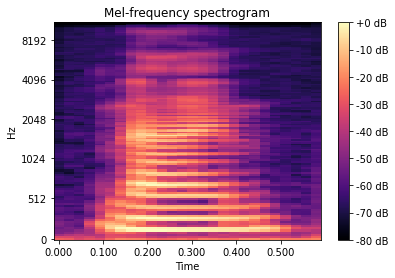

In [73]:
check = 10
get_audio_info(traintext[check], True, trainlabels[check].item())

In [74]:
class AudioClassifier(nn.Module):
    def __init__(self, num_feature_maps, layers):
        super().__init__()
        self.conv_layer = nn.Sequential(
            nn.Conv2d(1, num_feature_maps, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(num_feature_maps, num_feature_maps//2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(num_feature_maps//2),
            nn.LeakyReLU(inplace=True),
            
            nn.Conv2d(num_feature_maps//2, num_feature_maps//4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(num_feature_maps//4),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(num_feature_maps//4, 1, kernel_size=4, stride=1, padding=0),
            nn.Flatten()
        )
        
        self.classifier = nn.ModuleList(
            [nn.Linear(layers[i-1], layers[i]) for i in range(1, len(layers))]
        )
        
    def forward(self, x):
        a = self.conv_layer(x)
        for layer in self.classifier:
            a = layer(a)
        return a # as logits

In [75]:
num_feature_maps = 256
layers = [484, 128, 64, 32, 10]

In [82]:
clf = AudioClassifier(num_feature_maps, layers).to(device)

In [83]:
clf

AudioClassifier(
  (conv_layer): Sequential(
    (0): Conv2d(1, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.01, inplace=True)
    (5): Conv2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU(inplace=True)
    (8): Conv2d(64, 1, kernel_size=(4, 4), stride=(1, 1))
    (9): Flatten(start_dim=1, end_dim=-1)
  )
  (classifier): ModuleList(
    (0): Linear(in_features=484, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=64, bias=True)
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): Linear(in_features=32, out_features=10, bias=True)
  )
)

In [84]:
optim = torch.optim.Adam(lr=LR, params=clf.parameters(), betas=(0.5, 0.99))
loss_fn = nn.CrossEntropyLoss()

In [85]:
def accuracy(y_pred, y_true):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100
    return acc

In [86]:
def train_step(model, dataloader, optim, loss_fn, accuracy_fn):
    train_loss = 0.0
    train_acc = 0.0
    
    model.train()
    for batch, (X,y,txt) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        
        
        
        y_logits = model(X).to(device)
        y_preds = torch.softmax(y_logits, dim=1).argmax(dim=1).to(device)
        
        acc = accuracy_fn(y_preds, y)
        loss = loss_fn(y_logits, y)
        
        optim.zero_grad()
        loss.backward()
        optim.step()
        
        train_loss += loss.item()
        train_acc += acc
        
        if batch % 50 == 0:
            sample = random.randint(0, BATCH_SIZE-2)
            print(f"\tBatch {batch}: Train loss: {loss:.5f} | Train accuracy : {acc:.2f}%")
            get_audio_info(txt[sample], label=y_preds[sample].item())
            print("----------------------------------------")
        
    train_loss /= len(dataloader)
    train_acc /= len(dataloader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

    
def eval_step(model, dataloader, optim, loss_fn, accuracy_fn):
    test_loss = 0.0
    test_acc = 0.0
    
    model.eval()
    with torch.inference_mode():
        for batch, (X,y,txt) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
        
            y_logits = model(X).to(device)
            y_preds = torch.softmax(y_logits, dim=1).argmax(dim=1).to(device)

            acc = accuracy_fn(y_preds, y)
            loss = loss_fn(y_logits, y)

            test_loss += loss.item()
            test_acc += acc

            if batch % 50 == 0:
                sample = random.randint(0, BATCH_SIZE-2)
                print(f"\tBatch {batch}: Test loss: {loss:.5f} | Test accuracy : {acc:.2f}%")
                get_audio_info(txt[sample], label=y_preds[sample].item())
                print("----------------------------------------")
        
        test_loss /= len(dataloader)
        test_acc /= len(dataloader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%")

In [87]:
for epoch in range(EPOCHS):
    print(f"Epoch {epoch}")
    train_step(clf, train_dataloader, optim, loss_fn, accuracy)
    eval_step(clf, test_dataloader, optim, loss_fn, accuracy)

Epoch 0
	Batch 0: Train loss: 2.30270 | Train accuracy : 8.59%
Label: 7
	

----------------------------------------
	Batch 50: Train loss: 0.22372 | Train accuracy : 93.36%
Label: 6
	

----------------------------------------
Train accuracy: 0.55724 | Train accuracy: 81.87%
	Batch 0: Test loss: 2.15988 | Test accuracy : 57.42%
Label: 0
	

----------------------------------------
Test accuracy: 2.16338 | Train accuracy: 53.92%
Epoch 1
	Batch 0: Train loss: 0.16466 | Train accuracy : 95.31%
Label: 1
	

----------------------------------------
	Batch 50: Train loss: 0.09670 | Train accuracy : 98.44%
Label: 8
	

----------------------------------------
Train accuracy: 0.13943 | Train accuracy: 95.95%
	Batch 0: Test loss: 0.21041 | Test accuracy : 94.53%
Label: 8
	

----------------------------------------
Test accuracy: 0.24323 | Train accuracy: 91.52%
Epoch 2
	Batch 0: Train loss: 0.15506 | Train accuracy : 94.92%
Label: 9
	

----------------------------------------
	Batch 50: Train loss: 0.07245 | Train accuracy : 98.44%
Label: 5
	

----------------------------------------
Train accuracy: 0.09437 | Train accuracy: 97.29%
	Batch 0: Test loss: 2.41550 | Test accuracy : 73.83%
Label: 9
	

----------------------------------------
Test accuracy: 3.05825 | Train accuracy: 72.38%
Epoch 3
	Batch 0: Train loss: 0.07262 | Train accuracy : 97.66%
Label: 2
	

----------------------------------------
	Batch 50: Train loss: 0.07951 | Train accuracy : 96.88%
Label: 2
	

----------------------------------------
Train accuracy: 0.07208 | Train accuracy: 97.98%
	Batch 0: Test loss: 0.12028 | Test accuracy : 96.09%
Label: 9
	

----------------------------------------
Test accuracy: 0.10707 | Train accuracy: 96.08%
Epoch 4
	Batch 0: Train loss: 0.06671 | Train accuracy : 97.27%
Label: 0
	

----------------------------------------
	Batch 50: Train loss: 0.09652 | Train accuracy : 96.48%
Label: 8
	

----------------------------------------
Train accuracy: 0.07305 | Train accuracy: 97.81%
	Batch 0: Test loss: 0.24636 | Test accuracy : 91.41%
Label: 4
	

----------------------------------------
Test accuracy: 0.24392 | Train accuracy: 91.59%


## The model reached a high train accuracy of 97%; a high test accuracy of 96%

**NOTE: There was a typo while printing after Test metrics, it should be "Test loss: .. | Test accuracy: ..." rather than "Test accuracy: 0.24392 | Train accuracy: 91.59%"
There was another typo for Train metrics. This will be fixed later.**